Sasha Bravo & Nathan Ferrari

In [265]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Hidden Markov Model Assignment

The robot can move on the cells with light background, but cannot go over the obstacles, which have the dark blue background.

In [266]:
# Boolean representation of a random maze. True=feasible, False=obstacle.
# Use the maze corresponding to your group!
#maze = np.ones((2, 5), dtype=bool)
maze = np.ones((4, 16), dtype=bool)
rows, cols = maze.shape
N = rows*cols
obstacles = [11,12,13,14,19,21,23,25,27,30,35,39,48,49,50,51,52,53,55,59,62]
#obstacles = [2,4,5]
for cell in obstacles:
    r = cell // cols
    c = cell % cols
    maze[r][c] = False

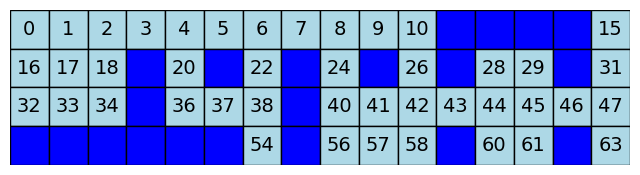

In [267]:
def plot_maze(ax, maze, skip_walls=True):
    cell_idx = 0
    rows, cols = maze.shape
    for r in range(rows):
        for c in range(cols):
            color = 'lightblue' if maze[r, c] == 1 else 'blue'
            ax.add_patch(patches.Rectangle((c, rows - 1 - r), 1, 1, edgecolor='black', facecolor=color))
            if maze[r, c] == 1 or not skip_walls:
                ax.text(c + 0.5, rows - 1 - r + 0.5, str(cell_idx), color='black', ha='center', va='center', fontsize=14)
            cell_idx += 1

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)


    ax.set_aspect('equal')
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 6))

plot_maze(ax, maze)

In [268]:
rows, cols = maze.shape
states = [(r, c) for r in range(rows) for c in range(cols) if maze[r, c]]

states_with_idx = []
for r in range(rows):
    for c in range(cols):
        state = (r, c)
        states_with_idx.append(state) if maze[r, c] else states_with_idx.append(None)
        
states_with_idx

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 None,
 None,
 None,
 None,
 (0, 15),
 (1, 0),
 (1, 1),
 (1, 2),
 None,
 (1, 4),
 None,
 (1, 6),
 None,
 (1, 8),
 None,
 (1, 10),
 None,
 (1, 12),
 (1, 13),
 None,
 (1, 15),
 (2, 0),
 (2, 1),
 (2, 2),
 None,
 (2, 4),
 (2, 5),
 (2, 6),
 None,
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 None,
 None,
 None,
 None,
 None,
 None,
 (3, 6),
 None,
 (3, 8),
 (3, 9),
 (3, 10),
 None,
 (3, 12),
 (3, 13),
 None,
 (3, 15)]

In [269]:
# Suggested names for the possible observations. If can be seen as a binary digit from 0 to 15, where the least significant bit indicates West.
# This may be usefule to code the emission matrix
letters = ['N', 'S', 'E', 'W']
vocabulary = []
for i in range(2**len(letters)):  # observations can be indexed with numbers 0 to 15
    binary = format(i, '04b')  # 4-bit format interpreted as possibility to move N,S,E,W
    combination = ''.join([letters[j] for j in range(4) if binary[j] == '1'])
    vocabulary.append(combination)

In [270]:
vocabulary

['',
 'W',
 'E',
 'EW',
 'S',
 'SW',
 'SE',
 'SEW',
 'N',
 'NW',
 'NE',
 'NEW',
 'NS',
 'NSW',
 'NSE',
 'NSEW']

In [271]:
pi = np.zeros(cols*rows, dtype=float)
for i in range(len(pi)):
    pi[i] = 1/len(states) if states_with_idx[i] is not None else 0
pi

array([0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.        , 0.        , 0.        , 0.        ,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.        ,
       0.02325581, 0.        , 0.02325581, 0.        , 0.02325581,
       0.        , 0.02325581, 0.        , 0.02325581, 0.02325581,
       0.        , 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.        , 0.02325581, 0.02325581, 0.02325581, 0.        ,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02325581,
       0.        , 0.02325581, 0.02325581, 0.02325581, 0.        ,
       0.02325581, 0.02325581, 0.        , 0.02325581])

## 1 HMM Definition and Trajectory Generation

### 1.1 Transition probability definition

Define the *transition probability matrix* $A$ corresponding to the robot maze. Consider that:

* The robot can only reach a neighboring cell.
* The robot can move North, South, East, West.
* Diagonal moves are not allowed.
* Passing over obstacles is not allowed.
* Feasible transitions are equally probable.

In [272]:
def count_neighbours(states, state):
    count = 0
    neighbours = []
    if (state[0], state[1]-1) in states:
        count += 1
        neighbours.append((state[0], state[1]-1))
    if (state[0], state[1]+1) in states:
        count += 1
        neighbours.append((state[0], state[1]+1))
    if (state[0]-1, state[1]) in states:
        count += 1
        neighbours.append((state[0]-1, state[1]))
    if (state[0]+1, state[1]) in states:
        count += 1
        neighbours.append((state[0]+1, state[1]))
    return count, neighbours

In [273]:
A = np.zeros((rows*cols, rows*cols))
for state in states:
    count_neighbours_res = count_neighbours(states, (state[0],state[1]))
    for neighbour in count_neighbours_res[1]:
        A[states_with_idx.index((state[0],state[1])), neighbour[1] + neighbour[0]*cols] = 1 / count_neighbours_res[0]

for row in A:
    for val in row:
        print(f"{val:.2f}", end=" ")
    print()

0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.33 0.00 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.33 0.00 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.50 0.00 0.50 0.00 0.00 0.

The transition probability matrix A models the motion of the robot inside the grid-based environment under strict physical constraints. You may transition only between neighboring cells in the four cardinal directions. You may not move diagonally, or through any obstacles. At each valid state, every feasible exit transition towards reachable neighbours is given equal probability, ensuring uniform redistribution of probability mass among admissible moves. With this construction the matrix will be stochastic and will model the local and non deterministic behaviour of the robot in maze.

The matrix A reflects the motion dynamics of the robot in the maze. For each state, it tells us the probability of going to any of the states in one time-step. A starting state is represented by a row in the matrix while each column corresponds to a destination state. According to the entries of the matrix, the robot can only move to its physically reachable neighbouring cells. The transition probabilities being equal reflects that we assume uniform random choice over all feasible movements.

The transition matrix $A$ indicates the probability of transitioning from one hidden state to another in the Hidden Markov Model. Each element $A_{ij}$ is the probability of going from state $i$ to state $j$ in one time step.

$$
A_{ij} = P(X_{t+1} = j \mid X_t = i).
$$

Here, the hidden state in time $t$ is $X_t$. In a grid world, actors can only transition to adjacent and accessible non-obstructed cells (North, South, East, West). Diagonal moves and moves through obstructed cells are not allowed.

If state i has n_i valid neighboring cells then any valid transition is equally likely.

$$
A_{ij} =
\begin{cases} 
\dfrac{1}{n_i}, & \text{if state } j \text{ is a valid neighbor of } i \\
0, & \text{otherwise}
\end{cases}
$$

### 1.2 Emission probability definition

Define the *emission probability matrix* $B$.
* After each move, the robot senses whether the cells to the North, South, East, West are feasible.
* There are 16 possible observations (previously defined variable `vocabulary`).

In [274]:
def vocabulary_counter(vocabulary, states):
    dict = {}
    for voc in vocabulary:
        dict[voc] = []
    for state in states:
        obs = ''
        if state is not None:
            if (state[0]-1, state[1]) in states:
                obs += 'N'
            if (state[0]+1, state[1]) in states:
                obs += 'S'
            if (state[0], state[1]+1) in states:
                obs += 'E'
            if (state[0], state[1]-1) in states:
                obs += 'W'
            
        dict[obs].append(state)
    
    return dict

In [275]:
B = np.zeros((rows*cols, len(vocabulary)))
dict = vocabulary_counter(vocabulary, states)
for voc in dict:
    for state in dict[voc]:
        B[state[0]*cols + state[1], vocabulary.index(voc)] = 1
        
## if any row sums to zero we have to put 1 in the first column
for row in B:
    if np.sum(row) == 0:
        row[0] = 1

for row in B:
    for val in row:
        print(f"{val:.2f}", end=" ")
    print()

0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.00 0.00 0.00 0.00 0.00 0.0

The emission probability matrix encodes the relationship between the robot’s position and its observations. In each position of the grid, the robot identifies whether the neighboring positions North, South, East, West are accessible (i.e. are free). Every possible observation defined in variable `vocabulary` corresponds to a specific combination of available directions. The matrix B is constructed such that for a given state, the column corresponding to the matching observation is assigned a probability of one, while all other entries are zero. The deterministic assignment assumes that the robot’s sensors totally detect the local configuration of free and blocked neighbouring cells.

An emission matrix $B$ provides the probability of obtaining a certain reading from a sensor given the robot’s state. Every element $B_{ik}$ indicates the probability for observing $O_k$ when the robot is in state $i$.

$$
B_{ik} = P(O_t = k \mid X_t = i)
$$

where the observation $O_t$ happened at the time $t$. The robot checks if the neighboring cells in the North, South, East,  West are free. Any combination of accessible paths pertains to a predetermined observation in the `vocabulary`.

The matrix is deterministic:

$$
B_{ik} =
\begin{cases} 
1, & \text{if observation } k \text{ matches the accessible neighbors of state } i \\
0, & \text{otherwise}
\end{cases}
$$

This reflects perfect sensing: the robot can fully detect which neighboring cells are free.

### 1.3 Trajectory Sampling

Sample and visualize a state and observation sequences $Z$ and $Y$ of
length $T = 20$ compatible with the previous hypotheses.

* Use the previously defined transition and emission matrices
* Consider the initial position equiprobable among the admissible states

In [304]:
def generate_sequence(T, A, B, pi, vocabulary):
    Z = np.empty(shape=T, dtype=int)
    Y = np.empty(shape=T, dtype=object)

    # initial state 
    Z[0] = np.random.choice(N, p=pi)
    Y[0] = vocabulary[np.random.choice(len(vocabulary), p=B[Z[0]])]

    for t in range(1, T):
        # transition
        Z[t] = np.random.choice(N, p=A[Z[t-1]])
        # emission according to noisy probabilities
        Y[t] = vocabulary[np.random.choice(len(vocabulary), p=B[Z[t]])]
    return Z, Y

T = 20
Z, Y = generate_sequence(T, A, B, pi, vocabulary)
print(Z)
print(Y)

[38 22  6  7  6 22 38 22 38 37 38 37 38 22 38 54 38 37 36 37]
['NSW' 'NS' 'SEW' 'EW' 'SEW' 'NS' 'NSW' 'NS' 'NSW' 'EW' 'NSW' 'EW' 'NSW'
 'NS' 'NSW' 'N' 'NSW' 'EW' 'NE' 'EW']


In this snippet, we sample and visualize a sequence of hidden states $Z$ and observations $Y$ of length $T=20$ from the Hidden Markov Model defined earlier. The starting state $Z_0$ is from the uniform distribution $\pi$ over all admissible states, meaning it would be uniformly random. For $t>0$, the states $Z_t$ are obtained from the transition matrix $A$, which gives the probabilities with which the state moves into an accessible neighboring cell:

$$
Z_0 \sim \pi, \quad
Z_t \sim P(X_t \mid X_{t-1}) = A_{Z_{t-1}}
$$

For every hidden state $Z_t$, the observation $Y_t$ is locked in by the emission matrix $B$. This matrix captures the robot’s immediate sensory input—what adjacent cells are free:

$$
Y_t = O_k \quad \text{such that } B_{Z_t, k} = 1
$$

Here’s the kicker: this setup creates sequences $(Z, Y)$ that align perfectly with the model’s rules. The robot only moves where it can, and at each step, it sees exactly which nearby cells are open.


## 2 Decoding and inference

### 2.1 Likelihood

Compute the likelihood of the obtained observation sequence $Y$.

The likelihood is the probability of having a specific sequence of observations Y.
To compute the likelihood is used the forward algorithm that compute for every t the probabilities of every state taking in consideration A and B matrixes following the following formulas:

Initialization (for each state i):

$$
\alpha_1(i) = \pi_i\, b_i(y_1)
$$

Recursion (for each time $t = 2, \dots, T$ and state $j$):


$$
\alpha_t(j) = \left( \sum_{i=1}^N \alpha_{t-1}(i)\, a_{ij} \right) b_j(y_t)
$$

where $\pi_i$ is the initial probability of being in state $i$, $a_{ij}$ is the element in position $(i, j)$ of the transition matrix $A$, and $b_j(y_t)$ is the emission probability of observing $y_t$ in state $j$, as defined by the emission matrix $B$.



In [277]:
def likelihood(A, B, pi, Y):
    alpha_all = np.zeros((T, N))

    for t in range(T):
        for z_t in range(N):
            if t == 0:
                alpha_all[t, z_t] = pi[z_t] * B[z_t, vocabulary.index(Y[t])]
            else:
                for z_prev in range(N):
                    alpha_all[t, z_t] += alpha_all[t-1, z_prev] * A[z_prev, z_t] * B[z_t,vocabulary.index(Y[t])]

    #print(alpha_all)           
    P_Y = np.sum(alpha_all[T-1, :])
    return P_Y

In [305]:
print(f"The probability of our sequence is: {float(likelihood(A, B, pi, Y))}")

The probability of our sequence is: 4.615303726861451e-09


### 2.1 Decoding 

Obtain the most probable state sequence, given the observation sequence $Y$.

In [279]:
def viterbi(A, B, pi, Y):
    v_all = np.zeros((T, N))
    bp_all = np.zeros((T, N), dtype=int)

    for i in range(N):
        v_all[0, i] = pi[i] * B[i, vocabulary.index(Y[0])]

    for t in range(1, T):
        for j in range(N):
            max_val = -1
            max_idx = -1
            for i in range(N):
                val = v_all[t-1, i] * A[i, j]
                if val > max_val:
                    max_val = val
                    max_idx = i
            v_all[t, j] = max_val * B[j, vocabulary.index(Y[t])]
            bp_all[t, j] = max_idx
            
    Z_vit = np.zeros(T, dtype=int)
    Z_vit[T - 1] = np.argmax(v_all[T - 1]) 
    for t in range(T - 2, -1, -1):
        Z_vit[t] = bp_all[t + 1, Z_vit[t + 1]] 

    return Z_vit

In [306]:
Z_vit = viterbi(A, B, pi, Y)
print([states_with_idx[z][1]+states_with_idx[z][0]*cols for z in Z_vit])
print([int(z) for z in Z])
Z_vit_list = [states_with_idx[z][1]+states_with_idx[z][0]*cols for z in Z_vit]

diffs = [a - b for a, b in zip(Z, Z_vit_list)]
res = [f'error at pos {i}' if int(z) != 0 else 'correct' for i,z in enumerate(diffs)]
print(res)

mismatches = sum(r != "correct" for r in res )
print(f"mismatch: {mismatches/len(res)}")

[38, 22, 6, 5, 6, 22, 38, 22, 38, 37, 38, 37, 38, 22, 38, 54, 38, 37, 36, 37]
[38, 22, 6, 7, 6, 22, 38, 22, 38, 37, 38, 37, 38, 22, 38, 54, 38, 37, 36, 37]
['correct', 'correct', 'correct', 'error at pos 3', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct']
mismatch: 0.05


The Viterbi algorithm is used to compute the most probable hidden state sequence for an observation sequence $Y = (y_1, y_2,..., y_T)$.
To find the best sequence, we need to find the probability of being in each state. We also want the max one for each t steps. Viterbi verifies both matrix A and matrix B for applicable matrices as per the following formula.

Initialization (for each state $i$).

$$
\delta_1(i) = \pi_i\, b_i(y_1)
$$
Recursion (for each time $t = 2, \dots, T$ and state $j$).

$$
\delta_t(j) = \max_{i=1}^N \left[ \delta_{t-1}(i)\, a_{ij} \right] b_j(y_t)
$$

Backtracking.

$$
q_T^* = \arg\max_{i=1}^N \delta_T(i)
$$

$$
q_t^* = \psi_{t+1}(q_{t+1}^*), \quad t = T-1, \dots, 1
$$

where $\pi_i$ is the initial probability of being in state $i$, $a_{ij}$ is the $(i, j)$ entry of the transition matrix $A$, and $b_j(y_t)$ is the probability of observing $y_t$ in state $j$, as defined by the emission matrix $B$.

### 2.2 Filtering

Obtain the filtering distribution $P(z_t \mid y_{1:t})$ at each time step $t$.

In [281]:
def filtering(A, B, pi, Y):
    alpha_all = np.zeros((T, N))

    for t in range(T):
        for z_t in range(N):
            if t == 0:
                alpha_all[t, z_t] = pi[z_t] * B[z_t, vocabulary.index(Y[t])]
            else:
                for z_prev in range(N):
                    alpha_all[t, z_t] += alpha_all[t-1, z_prev] * A[z_prev, z_t] * B[z_t,vocabulary.index(Y[t])]
        alpha_all[t, :] = alpha_all[t, :] / np.sum(alpha_all[t, :])
    #print(alpha_all)           
    return alpha_all

In [307]:
alpha_all = filtering(A, B, pi, Y)
for t in range(T):
    print(f"t = {t}, alpha = {alpha_all[t]}")

t = 0, alpha = [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.33333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.33333333 0.         0.         0.
 0.         0.         0.         0.         0.         0.33333333
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
t = 1, alpha = [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
t = 2, alpha = [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [283]:
def plot_heatmap(alpha_t, t):
    grid = alpha_t.reshape((4, 16))

    plt.figure(figsize=(5, 5))
    im = plt.imshow(grid, origin='upper', cmap='viridis',vmax=1)
    plt.colorbar(im, label='P(z_t = cell | Y1:t)')
    plt.title(f'Filtering heatmap at time t = {t}')
    plt.xlabel('column')
    plt.ylabel('row')
    plt.tight_layout()
    plt.show()

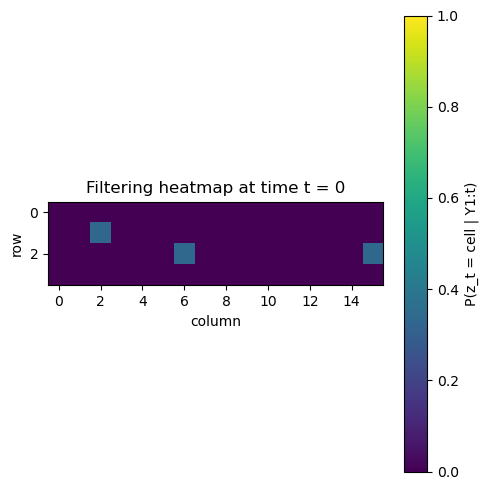

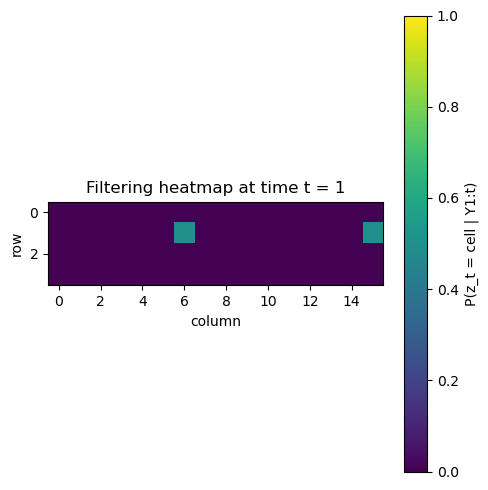

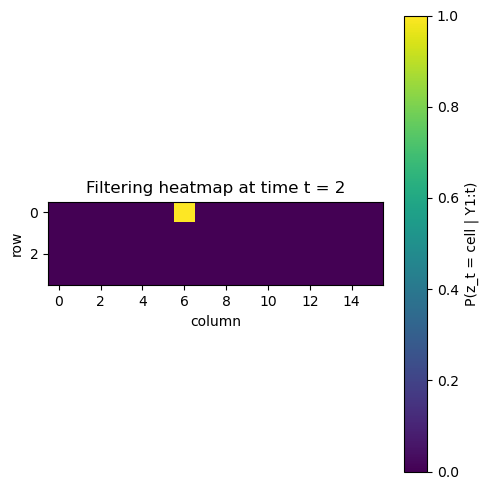

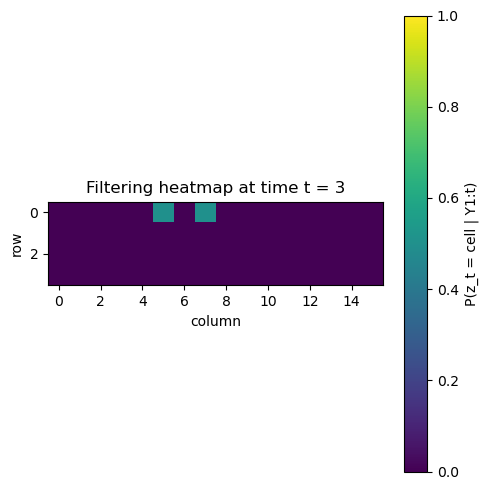

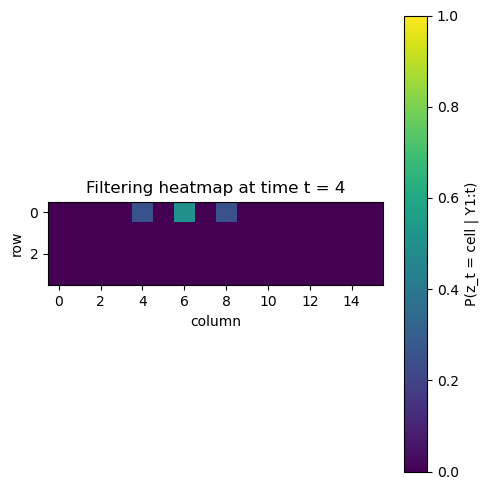

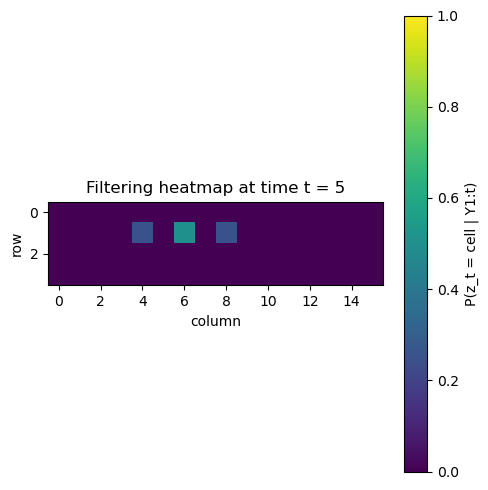

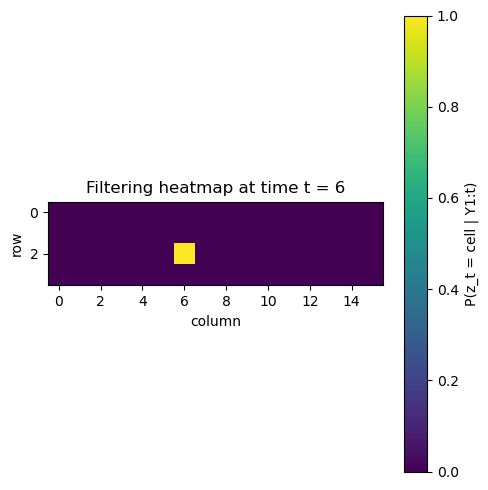

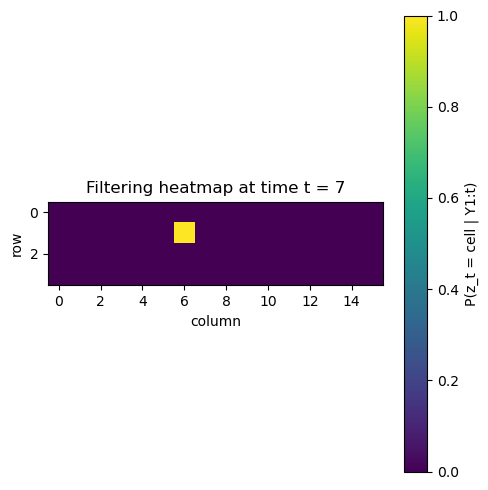

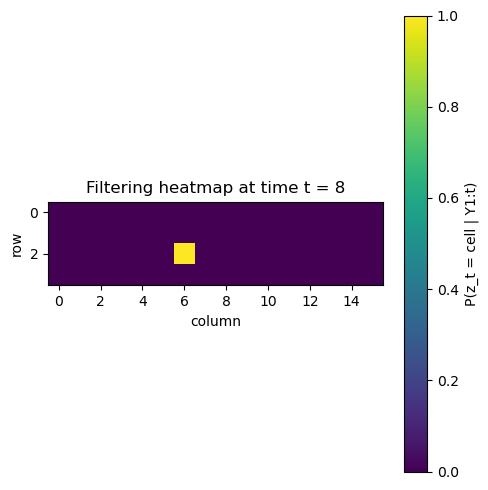

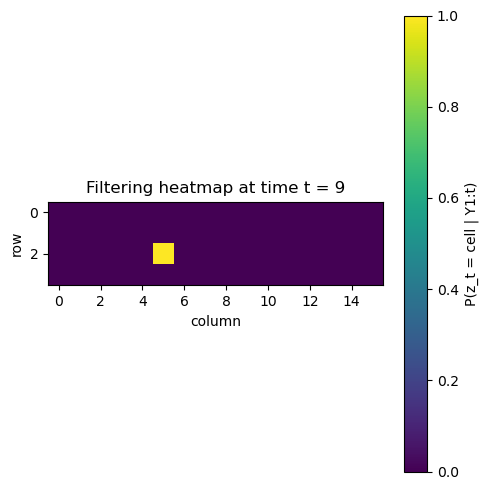

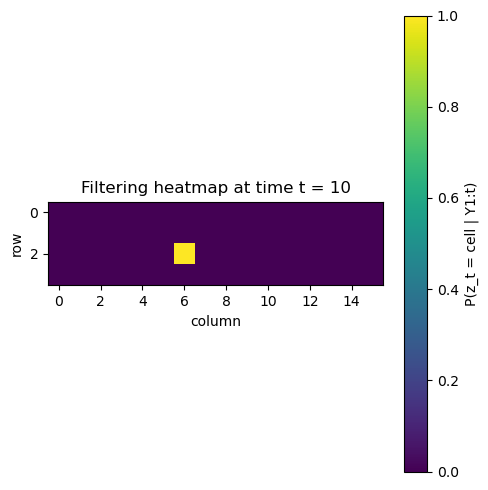

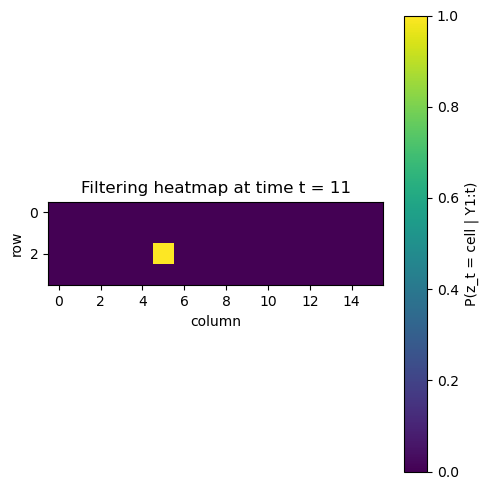

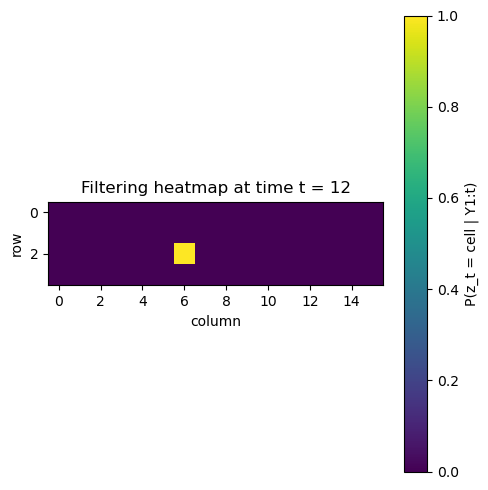

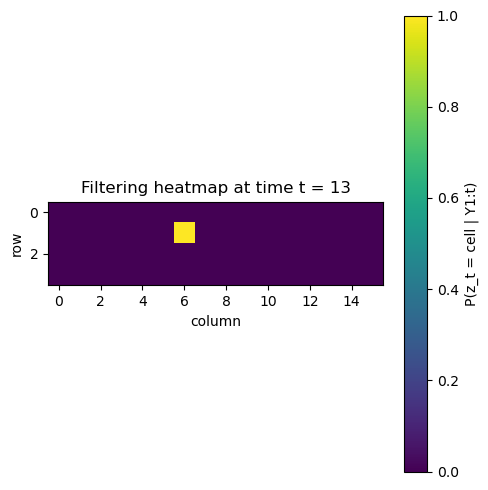

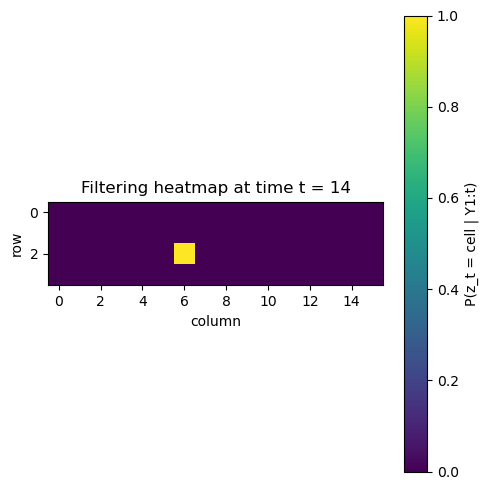

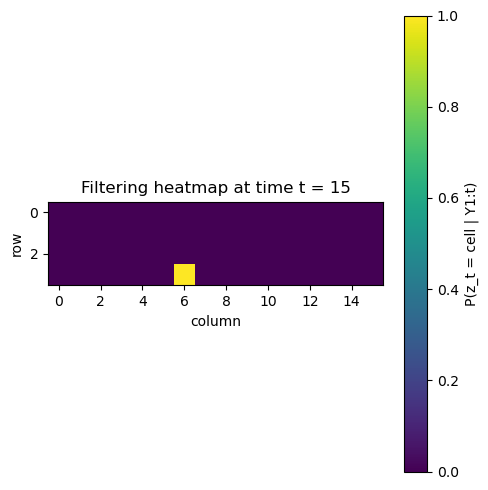

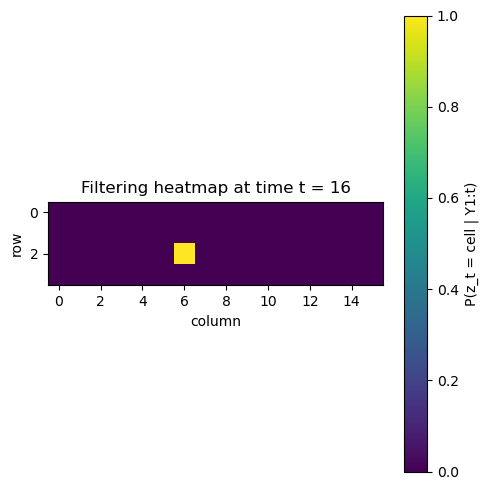

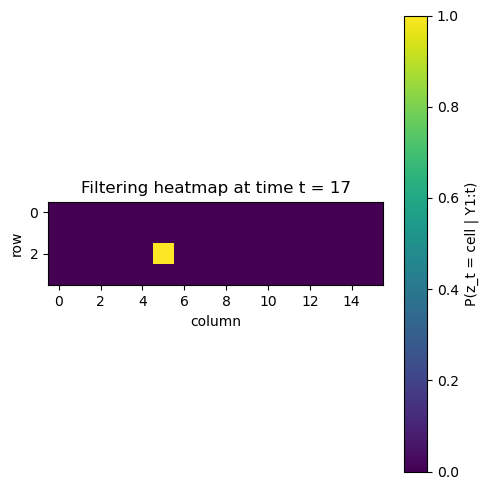

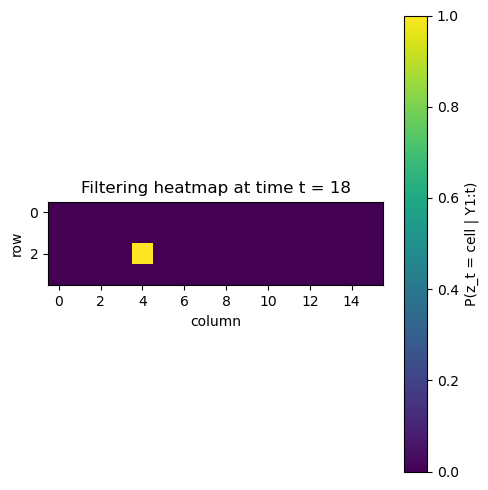

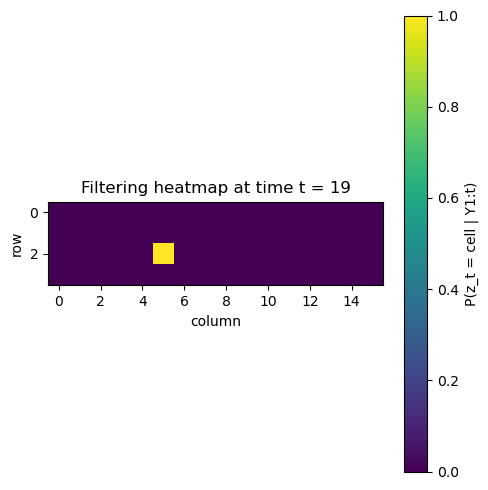

In [308]:
for t in range(T):
    plot_heatmap(alpha_all[t],t)

In *filtering* for Hidden Markov Models (HMMs), we take into account all the observations made up to each time step.  
The goal of this algorithm is to estimate the probability distribution over the agent’s position in every cell, given all the observations available up to time \( t \).

For example, if we are at time \( t = 4 \), the filtering algorithm computes the probability of being in each cell by using both the transition model and all previous observations — specifically those from \( t = 1, 2, 3 \) — together with the current observation.

The algorithm it's a modified forward that at the end of the loop over a specific time t normalize the probabilities to sum to one.

To better visualize our results, we decided to use a heatmap of the maze to represent the intensity of the probabilities associated with each cell.  
If a cell appears completely yellow, it means that the probability of being in that cell is maximal; we are therefore (ideally) 100% certain that the agent is located there.

### 2.3 Noisy observations

Repeat steps 2.1 and 2.2 in the presence of sensor error noise. In particular, consider that:
  * With probability $1-\epsilon$, the sensor provides the correct reading
  * With probability $\epsilon$, the sensor returns a wrong reading. 
  * The $\epsilon$ probability is equally split among all wrong readings.
  * Set $\epsilon=0.2$. Optionally, test also other values.

In [285]:
B_noisy = B.copy()
noise_level = 0.2
for i in range(B_noisy.shape[0]):
    for j in range(B_noisy.shape[1]):
        if B_noisy[i, j] > 0:
            B_noisy[i, j] = B_noisy[i, j] - noise_level
        else:
            B_noisy[i, j] = (noise_level / (B_noisy.shape[1] - 1))
#print(B_noisy)
#print the sum of each row to verify they sum to 1
#for row in B_noisy:
#    print(f"Sum of row: {np.sum(row)}")

In [286]:
Z_noisy, Y_noisy = generate_sequence(T, A, B_noisy, pi, vocabulary)
print(Z_noisy)
print(Y_noisy)

[ 8  9 10 26 10 26 42 41 40 56 40 56 40 41 40 41 57 56 57 58]
['SEW' 'EW' 'SW' 'NS' 'NSW' 'NS' 'NSEW' 'SEW' 'NSE' 'NE' 'NSE' 'NE' 'NSE'
 'SEW' 'NSE' 'SEW' 'NEW' 'E' 'NEW' 'NW']


In [287]:
print(f"The probability of our sequence is: {float(likelihood(A, B_noisy, pi, Y_noisy))}")

The probability of our sequence is: 6.768789440495186e-15


In [288]:
Z_vit = viterbi(A, B_noisy, pi, Y_noisy)
print([states_with_idx[z][1]+states_with_idx[z][0]*cols for z in Z_vit])
print([int(z) for z in Z_noisy])
Z_vit_list = [states_with_idx[z][1]+states_with_idx[z][0]*cols for z in Z_vit]

diffs = [a - b for a, b in zip(Z_noisy, Z_vit_list)]
res = [f'error at pos {i}' if int(z) != 0 else 'correct' for i,z in enumerate(diffs)]
print(res)

mismatches = sum(r != "correct" for r in res )
print(f"mismatch: {mismatches/len(res)}")

[8, 9, 10, 26, 10, 26, 42, 41, 40, 56, 40, 56, 40, 41, 40, 41, 57, 56, 57, 58]
[8, 9, 10, 26, 10, 26, 42, 41, 40, 56, 40, 56, 40, 41, 40, 41, 57, 56, 57, 58]
['correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct']
mismatch: 0.0


t = 0, alpha = [0.00251889 0.1511335  0.1511335  0.00251889 0.1511335  0.00251889
 0.1511335  0.00251889 0.1511335  0.00251889 0.00251889 0.
 0.         0.         0.         0.00251889 0.00251889 0.00251889
 0.00251889 0.         0.00251889 0.         0.00251889 0.
 0.00251889 0.         0.00251889 0.         0.00251889 0.00251889
 0.         0.00251889 0.00251889 0.00251889 0.00251889 0.
 0.00251889 0.00251889 0.00251889 0.         0.00251889 0.1511335
 0.00251889 0.00251889 0.00251889 0.00251889 0.00251889 0.00251889
 0.         0.         0.         0.         0.         0.
 0.00251889 0.         0.00251889 0.00251889 0.00251889 0.
 0.00251889 0.00251889 0.         0.00251889]
t = 1, alpha = [2.31071547e-03 2.35806620e-03 2.36753634e-03 2.72740187e-01
 1.70462617e-04 2.72740187e-01 1.70462617e-04 2.72740187e-01
 1.70462617e-04 1.39779346e-01 1.13641744e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.68208722e-05
 1.42052181e-04 2.38647663e-03 2.35806620e-03 0.000

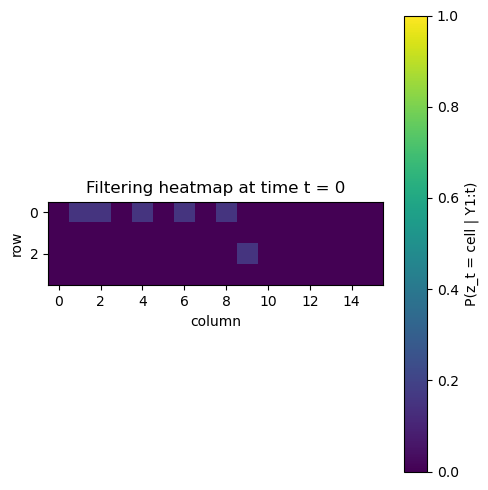

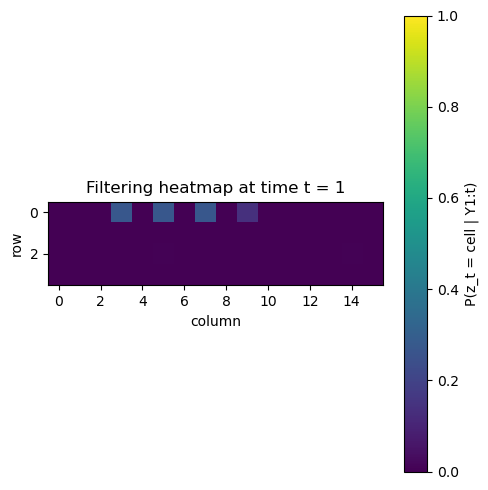

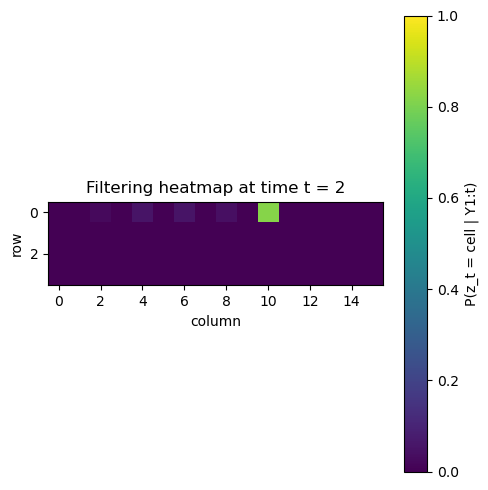

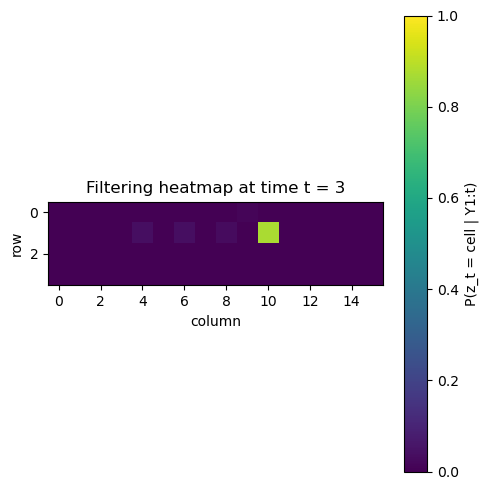

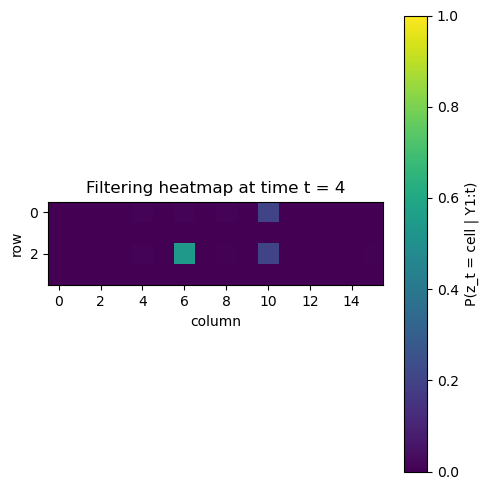

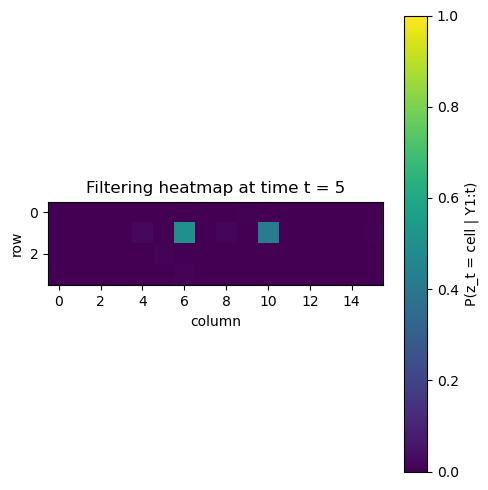

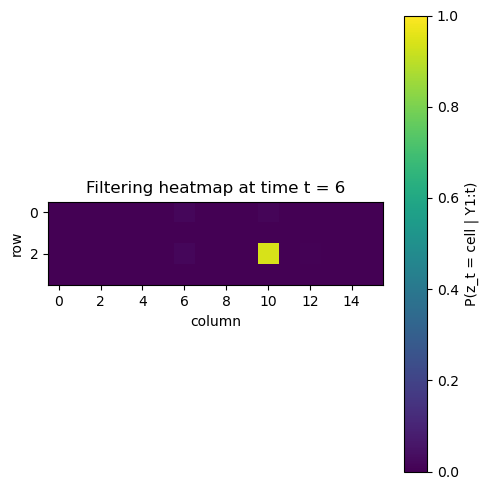

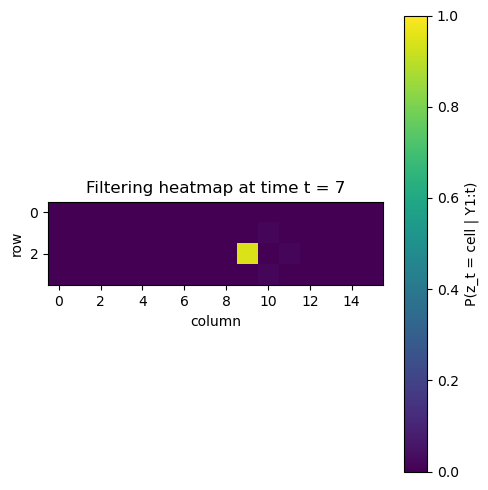

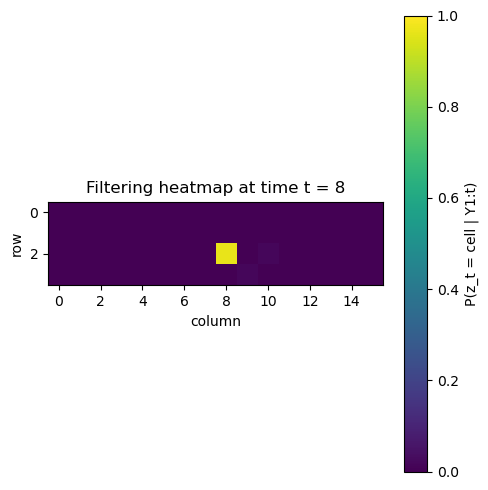

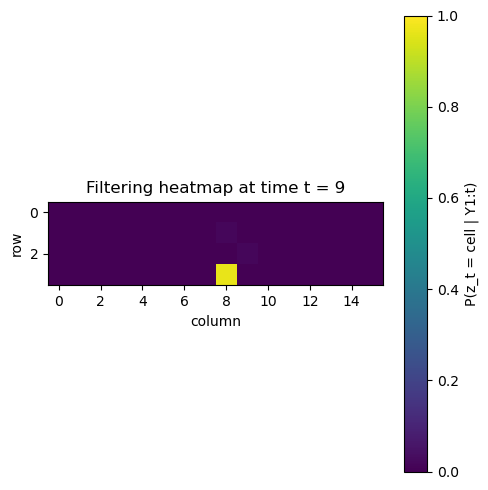

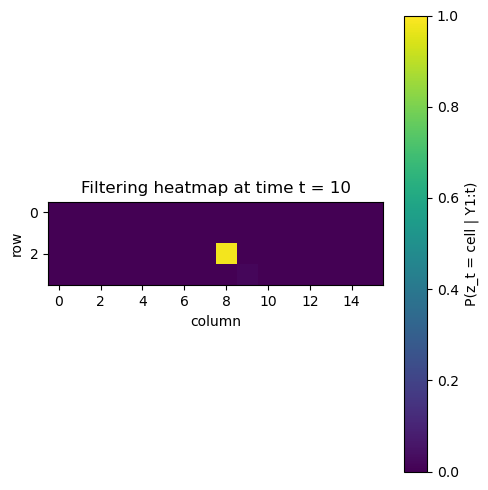

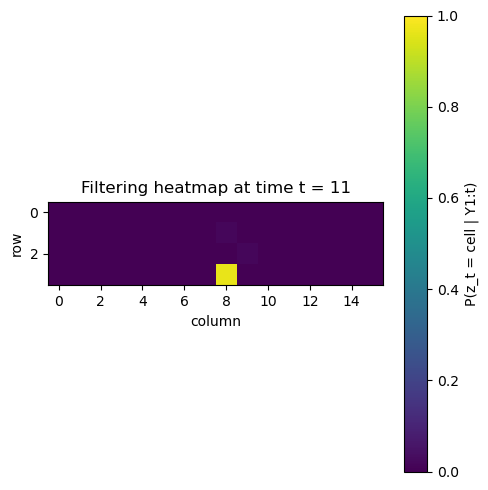

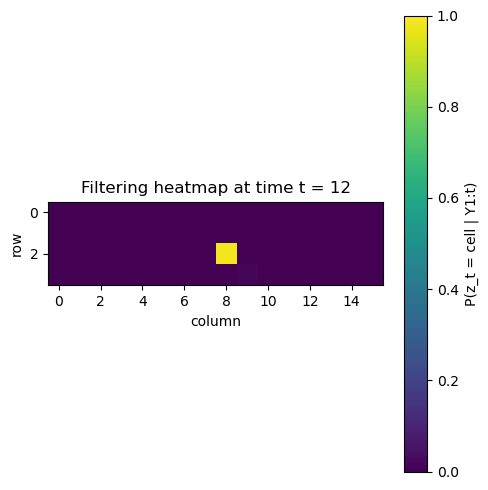

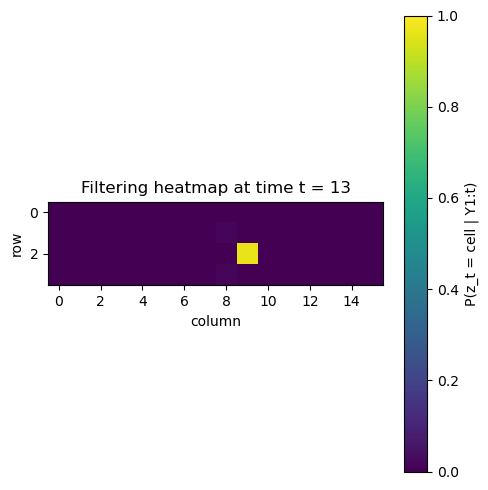

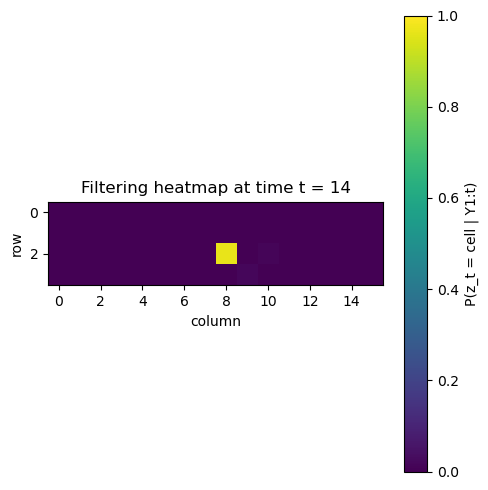

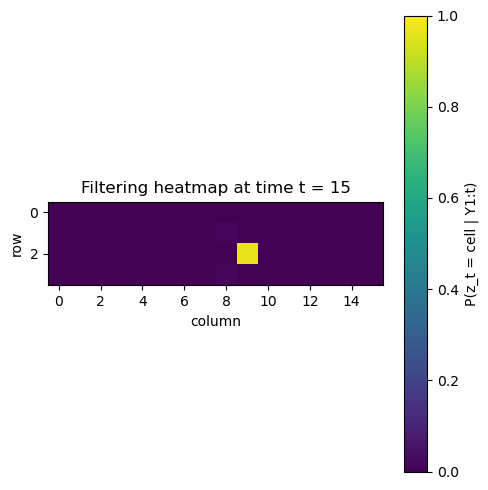

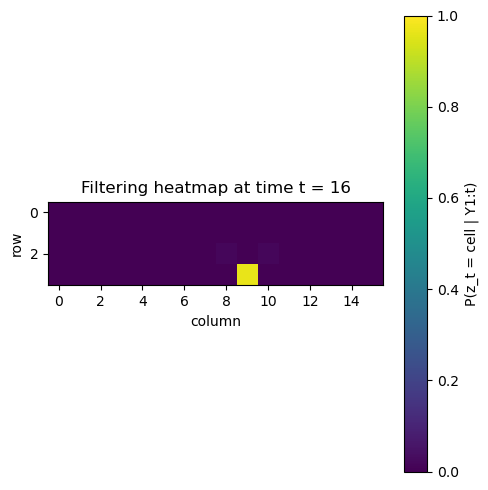

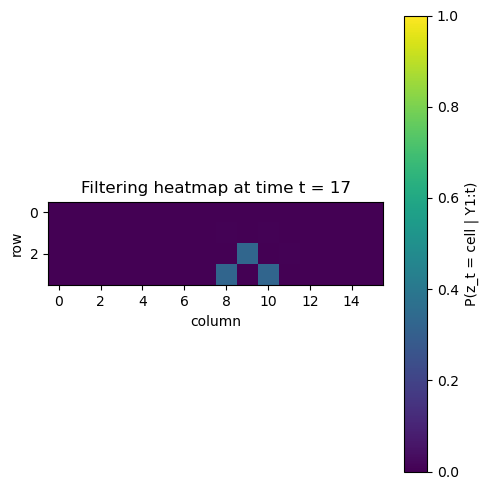

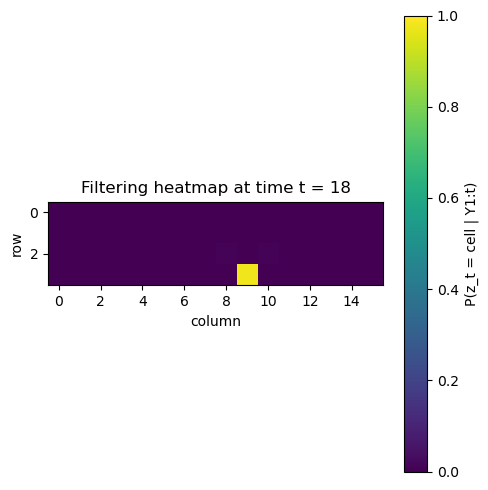

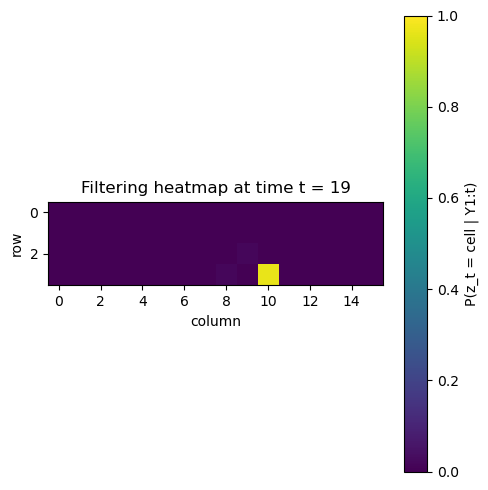

In [289]:
alpha_all = filtering(A, B_noisy, pi, Y_noisy)
for t in range(T):
    print(f"t = {t}, alpha = {alpha_all[t]}")
for t in range(T):
    plot_heatmap(alpha_all[t],t)

Noise in observations eliminates the possibility of having complete certainty about a reading.  
In our case, we assume a noise level of $\epsilon=0.2$, which means that the probability of receiving the *correct* observation is $1-\epsilon$.

The remaining probability (0.2) is **divided equally** among all possible *incorrect* observations.

This introduces uncertainty into the observation model (the matrix B), as the agent may receive an incorrect reading. As explained above, the value of \( Z[t] \) is sampled “randomly” according to the probabilities of the observation.  
This means that the agent may select an incorrect observation, thus influencing all subsequent belief updates.

After modifying the observation matrix \( B \) to include noise, we recalculate the results of points **2.1** and **2.2** to observe how noise influences the agent's choices.

As before, heatmaps help us visualise the evolution of the probability distribution and understand how the sequence of observations conditions the estimated position.

-------

When a new sequence is generated, that will possibly contain at least one error. the likelyhood is recomputed and it will be lower than the previously computed one, than viterbi will esteem as most proable path a path that will be slightly different than the original because errors interfeers with that computation.

Finally with the use of the filtering when an error is committed it can be seen by the creation of a "flower" around the last cell, or the small shadow around some cells that are mostly unprobable due to an improbable error.

## 3 Analysis and discussion

Comment the techniques applied and the obtained results.

The code is kept as easy and correlated to the theory as possible. We decided to take the code saw in class and in some cases modify it to stay more alligned with the theory, so without the use of vectors and similar used in faster and more efficent versions of the algorithm. as for the creation of the maze and the istantiation of the problem we have a general code that simply changing the obstacle list can change the maze and use another layout.

For the results of each algorithm they are as expected. The more interesting results are the viterbi and the heatmaps created by the filtering.
In the cases depicted above there could be mismatch even if the measurment is perfect due to some pattern in the maze, for example a cell neighbouring with 2 cells with the same observation. For the heatmap it can be observed the behaiviour created by the noise, when a wrong reading is saved (due to noise) it's created a sort of "flower" around the last cell for example t=17.